### Instalación de dependencias

In [ ]:
!pip --quiet install rlcard pettingzoo seaborn matplotlib numpy pandas pygame

311.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Imports necesarios

In [3]:
import abc
from pettingzoo.classic import rps_v2
import numpy as np
import random
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Nombres de las acciones de los entornos que veremos

In [4]:
RPS_CHOICES = ["Rock", "Paper", "Scissors"]
PD_CHOICES = ["Cooperate", "Defect"]

### Funciones auxiliares

In [5]:
def pretty_print_array(ar):
    return np.array_str(np.array(ar), precision=2, suppress_small=True)

def draw_history(history, title):
    data = pd.DataFrame({'Episode': range(1, len(history) + 1), title: history})
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y=title, data=data)

    plt.title(title + ' Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

# Entorno: Piedra, papel, tijera

En clase de teoría vimos brevemente el juego de piedra, papel, tijera como ejemplo de entorno sin equilibrios puros. Vamos a utilizarlo para empezar a ver algoritmos de aprendizaje por refuerzo multiagente. Los detalles sobre este entorno se pueden ver en la [documentación](https://pettingzoo.farama.org/environments/classic/rps/) de la libreria PettingZoo, análoga a Gymnasium pero para entornos multiagente.

En esta sesión, para simplificar la implementación de los algoritmos básicos, asumiremos las siguientes premisas:

* Hay observabilidad total
* Sólo hay un estado (vamos a ver únicamente juegos en forma normal en esta sesión)
* Los agentes actúan a la vez (en paralelo)

### Dos agentes aleatorios

En primer lugar vamos a ver cómo inicializar el entorno y ejecutarlo con agentes totalmente aleatorios:

In [6]:
env_rps = rps_v2.parallel_env(max_cycles=5, render_mode=None)  # Poned render_mode=None si la UI os da problemas
env_rps.reset()
total_rewards = [0, 0]
turn = 1

while env_rps.agents:
    print(f"Turn {turn}")
    actions = {agent: env_rps.action_space(agent).sample() for agent in env_rps.agents}
    observations, rewards, terminations, truncations, infos = env_rps.step(actions)
    print(f"Player 0: plays {RPS_CHOICES[actions['player_0']]}, observes: {RPS_CHOICES[observations['player_0']]}, gains: {rewards['player_0']}")
    print(f"Player 1: plays {RPS_CHOICES[actions['player_1']]}, observes: {RPS_CHOICES[observations['player_1']]}, gains: {rewards['player_1']}")
    total_rewards[0] += rewards['player_0']
    total_rewards[1] += rewards['player_1']
    turn += 1
print(f"Cumulative rewards: {total_rewards[0]}, {total_rewards[1]}")
env_rps.close()

Turn 1
Player 0: plays Scissors, observes: Paper, gains: 1
Player 1: plays Paper, observes: Scissors, gains: -1
Turn 2
Player 0: plays Rock, observes: Rock, gains: 0
Player 1: plays Rock, observes: Rock, gains: 0
Turn 3
Player 0: plays Scissors, observes: Rock, gains: -1
Player 1: plays Rock, observes: Scissors, gains: 1
Turn 4
Player 0: plays Scissors, observes: Paper, gains: 1
Player 1: plays Paper, observes: Scissors, gains: -1
Turn 5
Player 0: plays Paper, observes: Rock, gains: 1
Player 1: plays Rock, observes: Paper, gains: -1
Cumulative rewards: 2, -2


# Algoritmo: Joint Action Learning with Game Theory (JAL-GT)

El algoritmo JAL-GT (Joint Action Learning with Game Theory) es un algoritmo de diferencias temporales que utiliza Q-Learning para aproximar los valores estado-acción de todos los agentes. La política a seguir la marcará el concepto de solución, usando la tabla de valor Q como si fuera una matriz de recompensas (de ahí el "with Game Theory" del nombre del algoritmo).

El pseudocódigo del algoritmo es el siguiente ([Multi-Agent Reinforcement Learning, Albrecht et al. 2024, p.120](https://www.marl-book.com/download/)):

<div>
<img src="Algorithm7.png" width="500"/>
</div>

El símbolo $\Gamma$ (representando el concepto de "juego") se refiere a la matriz de recompensas que se calcula en base a partir de los valores de la función Q:

<div>
<img src="gamma.png" width="500"/>
</div>

Las diferencias con respecto al algoritmo Q-Learning que vimos en sesiones anteriores son las siguientes:

* Se construye una función de valor Q para cada agente, no sólo para el agente que está aprendiendo la política.
* La política no se calcula como $max_{a' \in A} Q(s'|a')$ sino que se calcula resolviendo el juego $\Gamma$ usando el concepto de solución elegido (e.g. equilibrio de Nash, minimax, óptimo de Pareto, etc.).
* La función de error (TD target) de diferencia temporal en este caso tampoco se calcula en base a $max_{a' \in A} Q(s'|a')$ sino que se calcula a partir del valor Q en el punto de equilibrio encontrado a partir del concepto de solución.

Para implementar el algoritmo, por lo tanto, necesitaremos los siguientes elementos:
* Un modelo de juego
* Un concepto de solución
* El algoritmo en sí

## Modelo de juego

Implementamos un modelo de juego como una tupla de número de agentes, un número de estados y un espacio de acciones. Podríamos añadir otros elementos, como por ejemplo un histórico de estados, de recompensas, de acciones o de observaciones pero para los juegos que vamos a ver en esta sesión no son necesarios todavía.

El espacio de acciones que genera la constructora es el espacio de **acciones conjuntas**: el conjunto de combinaciones de acciones para cada agente.

In [7]:
class GameModel:
    def __init__(self, num_agents, num_states, num_actions):
        self.num_agents = num_agents
        self.num_states = num_states
        self.num_actions = num_actions
        self.action_space = self.generate_action_space()

    def generate_action_space(self):
        actions_by_players = []
        for agent_id in range(self.num_agents):
            actions_by_players.append(range(self.num_actions))
        all_joint_actions = itertools.product(*actions_by_players)
        return [tuple(l) for l in all_joint_actions]

## Concepto de solución

El concepto de solución selecciona una estrategia pura _óptima_ para un agente determinado en un juego (matriz de recompensas). Qué estrategia se considera óptima es parte de la definición de este concepto de solución. Por ejemplo, si el concepto es la Pareto-eficiencia el agente debería escoger una acción individual que sea parte de la acción conjunta que sea óptimo de Pareto del juego.

Definimos un método abstract `solution_policy` que retorna una estrategia, potencialmente mixta, como una distribución de probabilidad sobre las acciones individuales, representando la calidad de cada acción según el concepto de solución. Además definimos un método para depurar la solución que usaremos más tarde.

In [8]:
class SolutionConcept(abc.ABC):
    @abc.abstractmethod
    def solution_policy(self, agent_id, state, game, q_table):
        pass

    @abc.abstractmethod
    def debug(self, agent_id, state, game, q_table):
        pass

Vamos a implementar ahora nuestro primer concepto de solución: Minimax.

In [9]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


class MinimaxSolutionConcept(SolutionConcept):
    # Minmax simple (de profundida 2) sin podas
    def opponent_max_values(self, agent_id, state, game, q_table):
        action_scores = []
        for action in range(game.num_actions):
            max_opponent_payoff = float('-inf')
            for opponent_action in range(game.num_actions):
                if agent_id == 0:  # Suponemos sólo dos agentes
                    joint_action = (action, opponent_action)
                else:
                    joint_action = (opponent_action, action)
                joint_action_index = game.action_space.index(joint_action)
                score = q_table[1 - agent_id][state][joint_action_index]
                if score > max_opponent_payoff:
                    max_opponent_payoff = score
            action_scores.append(max_opponent_payoff)
        return np.array(action_scores)

    def solution_policy(self, agent_id, state, game, q_table):
        vals = np.array(self.opponent_max_values(agent_id, state, game, q_table))
        return softmax(-vals)

    def debug(self, agent_id, state, game, q_table):
        vals = self.opponent_max_values(agent_id, state, game, q_table)
        print(f"La política minimax del agente {agent_id} minimiza los máximos valores del oponente, que son: {vals}")

## Algoritmo

Vamos a crear primero una clase abstracta para implementar diferentes algoritmos de aprendizaje por refuerzo multiagente. Definimos tres métodos abstractos:

* `learn`, para actualizar la tabla de valor Q
* `select_action`, para elegir una acción
* `explain`, como utilidad para extraer información relevante sobre la ejecución del algoritmo

In [10]:
class MARLAlgorithm(abc.ABC):
    @abc.abstractmethod
    def learn(self, joint_action, rewards, next_state: int, observations):
        pass

    @abc.abstractmethod
    def explain(self):
        pass

    @abc.abstractmethod
    def select_action(self, state):
        pass

Creamos el algoritmo como subclase de `MARLAlgorithm`. La constructora recibe el identificador del agente que usa el algoritmo para aprender, el modelo de juego y el concepto de solución. Aparte, se añaden algunos parámetros familiares: $\gamma$ (factor de descuento), $\alpha$ (tasa de aprendizaje), $\epsilon$ (coeficiente de exploración), y una semilla para el generador de números aleatorios.

La tabla `q_table` tiene las siguientes dimensiones: $N \times S \times AS$, donde $AS$ es el conjunto de acciones conjuntas y por lo tanto tiene tamaño $|N|^{|A|}$.

In [11]:
class JALGT(MARLAlgorithm):
    def __init__(self, agent_id, game: GameModel, solution_concept: SolutionConcept,
                 gamma=0.95, alpha=0.5, epsilon=0.2, seed=42):
        self.agent_id = agent_id
        self.game = game
        self.solution_concept = solution_concept
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = random.Random(seed)
        # Q: N x S x AS
        self.q_table = [[[0 for _ in range(len(self.game.action_space))]
                         for _ in range(self.game.num_states)]
                        for _ in range(self.game.num_agents)]
        # Política conjunta por defecto: distribución uniforme respecto
        # de las acciones conjuntas, para cada acción (pi(a | s))
        self.joint_policy = [[[1/self.game.num_actions] * self.game.num_actions
                              for _ in range(self.game.num_states)]
                             for _ in range(self.game.num_agents)]
        self.metrics = {"td_error": []}

Para el cálculo del valor de un estado para un agente, vamos a seguir la fórmula ([Multi-Agent Reinforcement Learning, Albrecht et al. 2024, p.120](https://www.marl-book.com/download/)):

$Value_i(\Gamma_{s'})=\sum_{a\in A} \Gamma_{s',i}(a)\pi^*_{s'} (a)$

Es decir, dado el juego $\Gamma$ definido a partir de ver la tabla de valor Q como si fuera una matriz de recompensas, el valor de un estado-acción $(s, a_i)$ para el agente $i$ es la utilidad esperada para $i$ según el conocimiento actual del agente: la suma de la recompensa para $i$, en $s$, para cada acción conjunta $a$ donde el agente realiza $a_i$, multiplicada por la probabilidad de realizar la acción conjunta $a$ según la política conjunta: $\pi^{*}(a|s)$.

Recordad, como hemos visto en teoría, que la política conjunta es el productorio de las políticas individuales, aquí implementado con `np.prod()`.

In [12]:
class JALGT(JALGT):
    def value(self, agent_id, state):
        value = 0
        for idx, joint_action in enumerate(self.game.action_space):
            payoff = self.q_table[agent_id][state][idx]
            joint_probability = np.prod([self.joint_policy[i][state][joint_action[i]]
                                         for i in range(self.game.num_agents)])
            value += payoff * joint_probability
        return value

El método `learn` implementa las líneas 8 y 9 del pseudocódigo del algoritmo. Para no calcularlas constantemente, añadimos un método `update_policy(agent_id)` que llamamos justo después de actualizar la función Q de cada agente.

In [13]:
class JALGT(JALGT):
    def update_policies(self, agent_id):
        self.joint_policy[agent_id] =\
            [self.solution_concept.solution_policy(agent_id, state, self.game, self.q_table)
             for state in range(self.game.num_states)]

    def learn(self, joint_action, rewards, next_state: int, observations):
        joint_action_index = self.game.action_space.index(joint_action)
        for agent_id in range(self.game.num_agents):
            agent_reward = rewards[agent_id]
            agent_game_value = self.value(agent_id, next_state)
            agent_q_value = self.q_table[agent_id][next_state][joint_action_index]
            td_target = agent_reward + self.gamma * agent_game_value - agent_q_value
            self.q_table[agent_id][next_state][joint_action_index] += self.alpha * td_target
            self.update_policies(agent_id)
            # Guardamos el error de diferencia temporal para estadísticas posteriores
            self.metrics['td_error'].append(td_target)

El método `select_action` implementa las líneas 5 y 6 del pseudocódigo. En este caso, la solución no depende directamente del valor, como en el caso del algoritmo original de Q-Learning ($\arg\max_{a\in A} Q^*(s,a)$), sino que se obtiene a partir del concepto de solución.

Aparte, también añadimos un método auxiliar para depurar.

In [14]:
class JALGT(JALGT):
    def solve(self, agent_id, state):
        return self.solution_concept.solution_policy(agent_id, state, self.game, self.q_table)

    def select_action(self, state):
        if self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.game.num_actions))
        else:
            return np.argmax(self.solve(self.agent_id, state))

    def explain(self):
        return self.solution_concept.debug(self.agent_id, 0, self.game, self.q_table)

## Experimento 1: dos agentes entrenando en paralelo

Ahora vamos a utilizar estas clases y la librería de PettingZoo para inicializar el entorno y los algoritmos, y entrenar. Definimos una función para realizar los experimentos:

In [15]:
def train_rps_2_agents(solution_concept, num_turns, gammas, alphas, epsilons, seeds):
    game_model = GameModel(num_agents=2, num_states=1, num_actions=3)
    algorithm_player_0 = JALGT(0, game_model, solution_concept,
                               gamma=gammas[0], alpha=alphas[0], epsilon=epsilons[0], seed=seeds[0])
    algorithm_player_1 = JALGT(1, game_model, solution_concept,
                               gamma=gammas[1], alpha=alphas[1], epsilon=epsilons[1], seed=seeds[1])
    env = rps_v2.parallel_env(max_cycles=num_turns, render_mode="ansi")
    env.reset()

    # Sólo tenemos un estado: es un juego en forma normal que siempre tiene la misma matriz de recompensa
    normal_form_state = 0
    cumulative_rewards = [[0, 0]]
    actions_played = [[], []]

    while env.agents:
        action_0 = algorithm_player_0.select_action(normal_form_state)
        action_1 = algorithm_player_1.select_action(normal_form_state)
        actions = {'player_0': action_0, 'player_1': action_1}
        actions_played[0].append(action_0)
        actions_played[1].append(action_1)
        observations, rewards, terminations, truncations, infos = env.step(actions)
        tuple_observations = (observations['player_0'], observations['player_1'])
        tuple_rewards = (rewards['player_0'], rewards['player_1'])
        algorithm_player_0.learn((action_0, action_1), tuple_rewards,
                                 normal_form_state, tuple_observations)
        algorithm_player_1.learn((action_0, action_1), tuple_rewards,
                                 normal_form_state, tuple_observations)
        cumulative_rewards.append([cumulative_rewards[-1][0] + tuple_rewards[0],
                                   cumulative_rewards[-1][1] + tuple_rewards[1]])

    env.close()
    return game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played

Configuramos, ejecutamos y analizamos resultados:

In [16]:
game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played =\
    train_rps_2_agents(solution_concept=MinimaxSolutionConcept(),
                       num_turns=10000, gammas=[0.95, 0.95], alphas=[0.1, 0.1],
                       epsilons=[0.2, 0.2], seeds=[0, 1])

# Recompensa acumulada. Debería ser [0, 0] en el infinito, si las estrategias son óptimas
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))
print("Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_table[0][0]).reshape((len(RPS_CHOICES), len(RPS_CHOICES))),
                  index=RPS_CHOICES, columns=RPS_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Explicación de la aplicación del concepto de solución:
algorithm_player_0.explain()

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

Recompensas acumuladas: -2656, 2656
Espacio de acciones conjuntas ordenado: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:
[-0.02 -1.01  0.99  0.99 -0.01 -1.01 -1.01  0.99 -0.01]
Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:
[-0.02 -1.01  0.99  0.99 -0.01 -1.01 -1.01  0.99 -0.01]
Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:
[ 0.02  1.01 -0.99 -0.99  0.01  1.01  1.01 -0.99  0.01]
Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:
[ 0.02  1.01 -0.99 -0.99  0.01  1.01  1.01 -0.99  0.01]
Matriz de recompensas estimadas para el agente 0:
              Rock     Paper  Scissors
Rock     -0.015515 -1.013014  0.987041
Paper     0.987161 -0.012768 -1.012751
Scissors -1.014966  0.987027 -0.012922
La política minimax del agente 0 minimiza los máximos valores

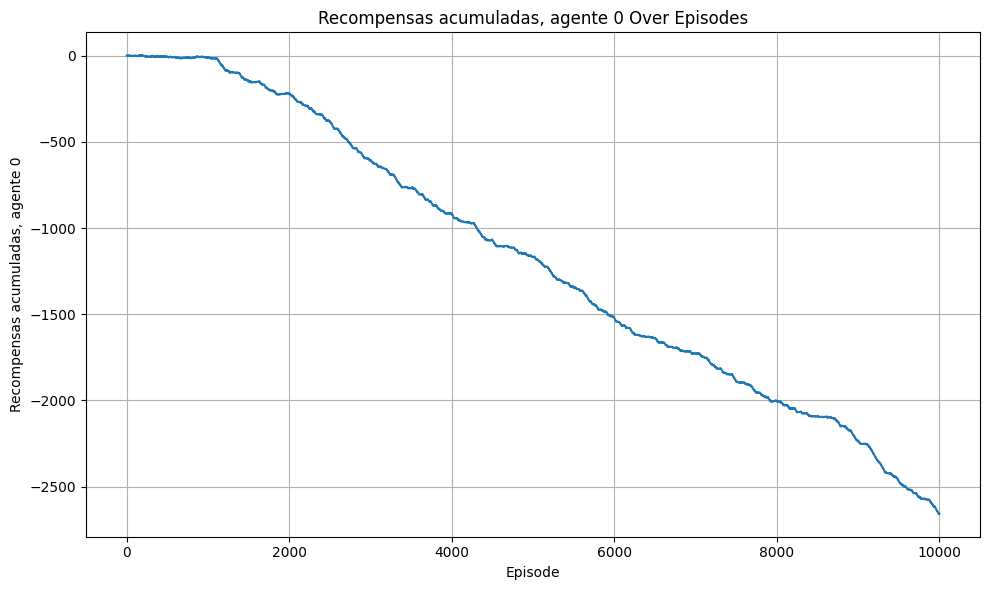

In [17]:
draw_history([cumulative_rewards[x][0] for x in range(len(cumulative_rewards))],
             "Recompensas acumuladas, agente 0")

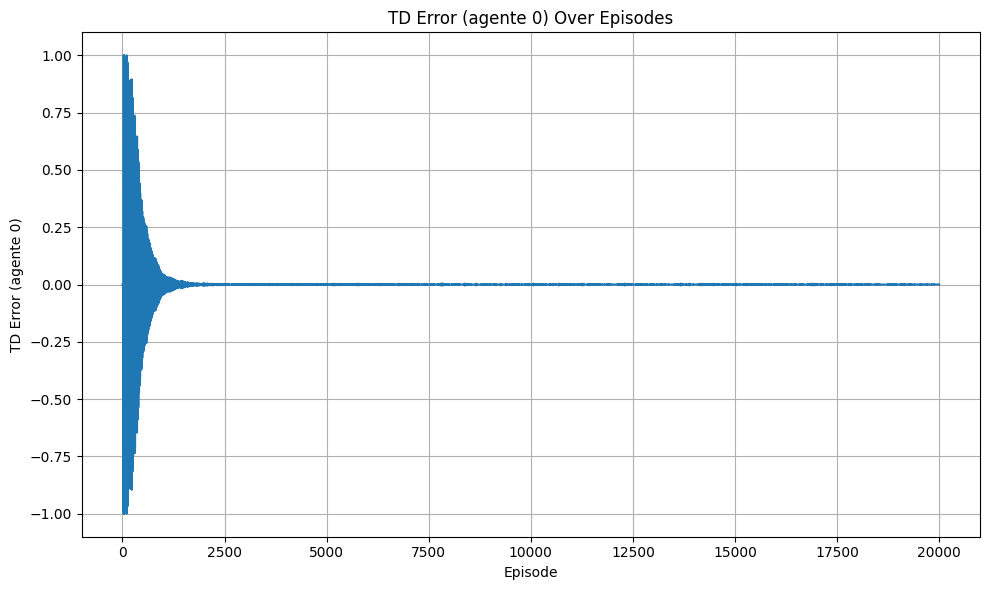

In [18]:
draw_history(algorithm_player_0.metrics["td_error"], "TD Error (agente 0)")

**¿Diríais que los agentes han entrenado bien? Si no es así, ¿qué creeis que ha pasado?**

**Si es necesario, repasad cómo funciona el algoritmo y comprobad con detenimiento qué valores hemos puesto a los parámetros por defecto.**

Si os ayuda, podéis inspeccionar las acciones que los agentes han tomado durante el entrenamiento:

In [19]:
# Primeras jugadas:
for i in range(10):
    print(f"0 juega {RPS_CHOICES[actions_played[0][i]]}, 1 juega {RPS_CHOICES[actions_played[1][i]]}")

0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock
0 juega Rock, 1 juega Rock


Una vez consigáis que empiece a entrenar, id comprobando el valor de las políticas. **Para agentes que se guían por el valor Minimax, ¿qué valor deberían tener las probabilidades de la política en este juego? Modificad parámetros del experimento hasta que consigáis aproximar la política a valores muy cercanos al teórico.**

## Experimento 2: Agente vs Random

Por mucho que hayáis conseguido aproximar la política bien, muy probablemente los valores Q no se ajusten perfectamente a las recompensas que da el entorno. Esto generalmente es debido a que cuando dos o más agentes están entrenando simultáneamente, se producen sesgos en el comportamiento basados en cualquier pequeña variación en las valoraciones inferidas de los otros agentes. Si el valor Minimax nos dice que el contrario debería valorar más Rock (y podría ser simplemente porque estamos en el turno 2 y en el turno 1 el contrario ganó con Rock) sabemos que deberíamos evitar Scissors, por lo que estamos sesgando la decisión inmediata. A la larga, esto se puede traducir en patrones raros donde una misma jugada se repite muchas veces hasta que el contrario se adapta, dando lugar a celdas de la tabla Q que están mejor calculadas que otras (simplemente por ley de los grandes números).

Vamos a ver qué pasa si entrenamos a nuestro agente JAL-GT a competir contra un agente totalmente aleatorio:

In [20]:
class RandomAlgorithm(MARLAlgorithm):
    def __init__(self, game, seed=42):
        self.game = game
        self.rng = random.Random(seed)

    def learn(self, joint_action, rewards, next_state: int, observations):
        pass

    def explain(self):
        print("Random algorithm")

    def select_action(self, state):
        return self.rng.choice(range(self.game.num_actions))

In [21]:
def train_rps_vs_random(solution_concept, num_turns, gamma, alpha, epsilon, seeds):
    game_model = GameModel(num_agents=2, num_states=1, num_actions=3)
    algorithm_player_0 = JALGT(0, game_model, solution_concept,
                               gamma=gamma, alpha=alpha, epsilon=epsilon, seed=seeds[0])
    algorithm_player_1 = RandomAlgorithm(game_model, seed=seeds[1])
    env = rps_v2.parallel_env(max_cycles=num_turns, render_mode="ansi")
    env.reset()

    # Sólo tenemos un estado: es un juego en forma normal que siempre tiene la misma matriz de recompensa
    normal_form_state = 0
    cumulative_rewards = [[0, 0]]
    actions_played = [[], []]

    while env.agents:
        action_0 = algorithm_player_0.select_action(normal_form_state)
        action_1 = algorithm_player_1.select_action(normal_form_state)
        actions = {'player_0': action_0, 'player_1': action_1}
        actions_played[0].append(action_0)
        actions_played[1].append(action_1)
        observations, rewards, terminations, truncations, infos = env.step(actions)
        tuple_observations = (observations['player_0'], observations['player_1'])
        tuple_rewards = (rewards['player_0'], rewards['player_1'])
        algorithm_player_0.learn((action_0, action_1), tuple_rewards,
                                 normal_form_state, tuple_observations)
        algorithm_player_1.learn((action_0, action_1), tuple_rewards,
                                 normal_form_state, tuple_observations)
        cumulative_rewards.append([cumulative_rewards[-1][0] + tuple_rewards[0],
                                   cumulative_rewards[-1][1] + tuple_rewards[1]])

    env.close()
    return game_model, algorithm_player_0, cumulative_rewards, actions_played

In [22]:
game_model, algorithm_player_0, cumulative_rewards, actions_played =\
    train_rps_vs_random(solution_concept=MinimaxSolutionConcept(),
                        num_turns=1500, gamma=0.95, alpha=0.1, epsilon=0.2, seeds=[0, 0])

# Recompensa acumulada. Debería ser [0, 0] en el infinito, si las estrategias son óptimas
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_table[0][0]).reshape((len(RPS_CHOICES), len(RPS_CHOICES))),
                  index=RPS_CHOICES, columns=RPS_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Explicación de la aplicación del concepto de solución:
algorithm_player_0.explain()

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

Recompensas acumuladas: -25, 25
Espacio de acciones conjuntas ordenado: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:
[-0.02 -1.02  0.98  0.98 -0.02 -1.02 -1.02  0.98 -0.02]
Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:
[-0.02 -1.02  0.98  0.98 -0.02 -1.02 -1.02  0.98 -0.02]
Matriz de recompensas estimadas para el agente 0:
              Rock     Paper  Scissors
Rock     -0.016121 -1.016112  0.982868
Paper     0.983617 -0.016194 -1.016256
Scissors -1.015341  0.984700 -0.015312
La política minimax del agente 0 minimiza los máximos valores del oponente, que son: [1.01610133 1.01624526 1.01533085]
Política del agente 0: [0.3332637  0.33321573 0.33352057]
Política del agente 1: [0.3332637  0.33321573 0.33352057]


**Modificad los parámetros del experimento para intentar que la matriz de recompensas esté cerca de los valores teóricos.**

**¿Qué conclusiones sacáis de este análisis? ¿Qué modelo creéis que converge antes en unos óptimos reales y por qué?**

# Experimento 3: otro concepto de solución (equilibrio de Nash)

Hemos usado el concepto de solución Minimax en el ejemplo anterior. Vamos a implementar otro concepto más: el equilibrio de Nash. Para esta implementación, vamos a replicar el método que hemos usado en clases de problemas para resolver este tipo de juegos con este concepto: el cruce de mejores respuestas. Vamos paso a paso.

Para empezar, vamos a definir una función para obtener todas las posibles estrategias combinadas de todos los agentes menos uno. Esto nos permitirá identificar más adelante el conjunto de acciones _casi-conjuntas_ para las que buscar mejores respuestas:

In [23]:
class NashSolutionConcept(SolutionConcept):
    def generate_others_actions(self, fixed_agent_id, num_agents, num_actions):
        # Lista con las estrategias que pueden seguir los demás agentes
        strategies_minus_me = [range(num_actions) if i != fixed_agent_id else [None]
                               for i in range(num_agents)]
        # itertools.product nos da el producto cartesiano
        return list(itertools.product(*strategies_minus_me))

A partir de una lista de acciones _casi-conjuntas_, para un agente y un estado, vamos a buscar la mejor respuesta para cada una. Iteramos sobre esta lista, encontrando la acción para la que nuestra recompensa estimada (a partir de la función Q) es más alta. Guardamos todas las mejores respuestas en un conjunto:

In [24]:
class NashSolutionConcept(NashSolutionConcept):
    def calculate_best_responses(self, agent_id, state, game, q_table):
        others_joint_actions = self.generate_others_actions(agent_id, game.num_agents, game.num_actions)
        best_responses = []
        for joint_action in others_joint_actions:
            max_payoff = float('-inf')
            best_response = None
            for action in range(game.num_actions):
                joint_action_copy = list(joint_action)
                joint_action_copy[agent_id] = action
                full_joint_action = tuple(joint_action_copy)
                joint_action_index = game.action_space.index(full_joint_action)
                payoff = q_table[agent_id][state][joint_action_index]
                if payoff > max_payoff:
                    max_payoff = payoff
                    best_response = full_joint_action
            best_responses.append(best_response)
        return set(best_responses)

Encontrar los equilibrios de Nash es tan sencillo como generar todos los conjuntos de mejores respuestas para todos los agentes y calcular la intersección (_el cruce_):

In [25]:
class NashSolutionConcept(NashSolutionConcept):
    def find_nash_equilibria(self, state, game, q_table):
        best_responses = [self.calculate_best_responses(i, state, game, q_table) for i in range(game.num_agents)]
        return list(set.intersection(*best_responses))

Con una lista de equilibrios de Nash, podríamos seguir varios métodos para obtener una política. Por ejemplo, hay métodos para calcular una estrategia mixta (probabilidades arbitrarias entre 0 y 1), o podríamos buscar el equilibrio que nos beneficie más.

Por simplicidad, en esta implementación simplemente nos vamos a quedar con el primer equilibrio que tengamos en la respuesta y usar la acción del agente en esa acción conjunta para poner su probabilidad a 1. Si no hay equilibrios de Nash, retornamos una política con una distribución de probabilidad uniforme:

In [26]:
class NashSolutionConcept(NashSolutionConcept):
    def solution_policy(self, agent_id, state, game, q_table):
        nash_equilibria = self.find_nash_equilibria(state, game, q_table)
        if len(nash_equilibria) > 0:
            equilibrium = nash_equilibria[0]
            probs = np.zeros(game.num_actions)
            probs[equilibrium[agent_id]] = 1
            return probs
        else:
            uniform_distribution = [1] * game.num_actions
            return uniform_distribution / np.sum(uniform_distribution)

    def debug(self, agent_id, state, game, q_table):
        best_responses = [self.calculate_best_responses(i, state, game, q_table) for i in range(game.num_agents)]
        for i in range(game.num_agents):
            print(f"Mejores respuestas para el agente {i}: {best_responses[i]}")
        print(f"El conjunto de equilibrios de Nash es: {self.find_nash_equilibria(state, game, q_table)}")

Entrenamos:

In [27]:
game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played =\
    train_rps_2_agents(solution_concept=NashSolutionConcept(),
                       num_turns=15, gammas=[0.95, 0.95], alphas=[0.1, 0.1],
                       epsilons=[0.4, 0.4], seeds=[0, 1])

# Recompensa acumulada. Debería ser [0, 0] en el infinito, si las estrategias son óptimas
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))
print("Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_table[0][0]).reshape((len(RPS_CHOICES), len(RPS_CHOICES))),
                  index=RPS_CHOICES, columns=RPS_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Explicación de la aplicación del concepto de solución:
algorithm_player_0.explain()

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

Recompensas acumuladas: -1, 1
Espacio de acciones conjuntas ordenado: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:
[-0.01 -0.19  0.    0.19  0.   -0.1  -0.1   0.1   0.  ]
Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:
[-0.01 -0.19  0.    0.19  0.   -0.1  -0.1   0.1   0.  ]
Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:
[ 0.01  0.19  0.   -0.19  0.    0.1   0.1  -0.1   0.  ]
Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:
[ 0.01  0.19  0.   -0.19  0.    0.1   0.1  -0.1   0.  ]
Matriz de recompensas estimadas para el agente 0:
              Rock     Paper  Scissors
Rock     -0.005447 -0.191161       0.0
Paper     0.190000  0.000000      -0.1
Scissors -0.100000  0.097834       0.0
Mejores respuestas para el agente 0: {(1, 0), (0, 2), (2, 1)}
Mejor

**Interpreta qué está ocurriendo cuando aplicamos equilibrio de Nash como concepto de solución implementado de esta manera (sólo para estrategias puras, o política totalmente aleatoria si no hay). ¿Qué mejoras aplicarías?**

# Experimento 4: juego de intereses mixtos (dilema del prisionero)

En esta sección vamos a explorar estas dos soluciones de concepto en un juego que no es puramente competitivo, sino de intereses mixtos: el dilema del prisionero. En PettingZoo no tenemos este juego incluido como entorno, pero sí podemos usar la librería para construir uno a mano. Tenéis el código en el fichero adjunto `prisoners_dilemma.py`.

La clase `Game` es una clase base que podéis usar para implementar juegos diferentes, como por ejemplo los de la colección de problemas (Teoría de Juegos). Este código está copiado del repositorio: [https://github.com/tianyu-z/pettingzoo_dilemma_envs](https://github.com/tianyu-z/pettingzoo_dilemma_envs).

In [28]:
import prisoners_dilemma

In [29]:
def train_pd(solution_concept, num_turns, gammas, alphas, epsilons, seeds):
    game_model = GameModel(num_agents=2, num_states=1, num_actions=2)
    algorithm_player_0 = JALGT(0, game_model, solution_concept, gamma=gammas[0], alpha=alphas[0], epsilon=epsilons[0], seed=seeds[0])
    algorithm_player_1 = JALGT(1, game_model, solution_concept, gamma=gammas[1], alpha=alphas[1], epsilon=epsilons[1], seed=seeds[1])
    env = prisoners_dilemma.parallel_env(max_cycles=1, render_mode="ansi")
    normal_form_state = 0
    cumulative_rewards = [[0, 0]]
    actions_played = [[], []]

    for i in range(num_turns):
        env.reset()
        while env.agents:
            action_0 = algorithm_player_0.select_action(normal_form_state)
            action_1 = algorithm_player_1.select_action(normal_form_state)
            actions = {'player_0': action_0, 'player_1': action_1}

            observations, rewards, terminations, truncations, infos = env.step(actions)

            tuple_observations = (observations['player_0'], observations['player_1'])
            tuple_rewards = (rewards['player_0'], rewards['player_1'])
            algorithm_player_0.learn((action_0, action_1), tuple_rewards,
                                     normal_form_state, tuple_observations)
            algorithm_player_1.learn((action_0, action_1), tuple_rewards,
                                     normal_form_state, tuple_observations)

            # Recolección de métricas
            actions_played[0].append(action_0)
            actions_played[1].append(action_1)
            cumulative_rewards.append([cumulative_rewards[-1][0] + tuple_rewards[0],
                                       cumulative_rewards[-1][1] + tuple_rewards[1]])
    return game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played

In [ ]:
game_model, algorithm_player_0, algorithm_player_1, cumulative_rewards, actions_played = \
    train_pd(solution_concept=NashSolutionConcept(),
             num_turns=15, gammas=[0.95, 0.95], alphas=[0.1, 0.1],
             epsilons=[0.2, 0.2], seeds=[0, 1])

# Recompensa acumulada
print(f"Recompensas acumuladas: {cumulative_rewards[-1][0]}, {cumulative_rewards[-1][1]}")

# Espacio de acciones conjuntas
print(f"Espacio de acciones conjuntas ordenado: {game_model.action_space}")

# Valores Q calculados por los dos agentes:
print("Valores Q calculados por el agente 0 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 0 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_0.q_table[0][0]))
print("Valores Q calculados por el agente 1 sobre el agente 0, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))
print("Valores Q calculados por el agente 1 sobre el agente 1, indexados por acciones conjuntas:")
print(pretty_print_array(algorithm_player_1.q_table[1][0]))

# Convertimos en un dataframe para mostrar la matriz de recompensas para el agente 0:
df = pd.DataFrame(np.array(algorithm_player_0.q_table[0][0]).reshape((len(PD_CHOICES), len(PD_CHOICES))),
                  index=PD_CHOICES, columns=PD_CHOICES)
print("Matriz de recompensas estimadas para el agente 0:")
print(df)

# Explicación de la aplicación del concepto de solución:
algorithm_player_0.explain()

# Política del agente 0:
print(f"Política del agente 0: {algorithm_player_0.solve(0, 0)}")

# Política del agente 1:
print(f"Política del agente 1: {algorithm_player_0.solve(0, 0)}")

TypeError: 'module' object is not callable

: 

Para estar seguros de si el resultado es correcto, podemos comprovar como está convergiendo el algoritmo. Por ejemplo, siguiendo la función de pérdida:

In [ ]:
draw_history(algorithm_player_0.metrics["td_error"], "TD Error (agente 0)")

**Ajusta los parámetros para conseguir que la curva de pérdida se estabilice y converja en el cero.**

**Una vez conseguido, comprueba si el orden de recompensas se mantiene sobre el teórico. Puede ser que no sea así, en tal caso, ¿podrías interpretar qué ocurre analizando el algoritmo?**

Una pista podría estar en la cuenta de qué acciones se han explorado:

In [ ]:
count_coop = 0
count_def = 0
for i in actions_played[0]:
    if i == 0:
        count_coop +=1
    else:
        count_def += 1
print(f"El agente 0 ha cooperado {count_coop} veces, traicionado {count_def} veces")

**Aplica el equilibrio de Nash como concepto de solución para este entorno, experimenta e interpreta los resultados.**

**Implementa una nueva solución de concepto basada en el Óptimo de Pareto y experimenta con ella.**

# Algoritmo: Joint Action Learning with Agent Modelling (JAL-AM)

Una segunda familia de algoritmos de aprendizaje por refuerzo multiagente es el de _juego ficticio_ o modelado de agentes, cuya idea principal es la de modelar, probabilísticamente, el comportamiento (la política) de los otros agentes a partir de la observación de las acciones y las recompensas que reciben. Dada una cantidad $C(a_j)$ que representa el número de veces que el agente $j$ ha seleccionado la acción $a_j$ en el pasado, se define un modelo $\hat{\pi}_j$:

$\hat{\pi}_j(a_j)=\frac{C(a_j)}{\sum_{a'_j} C(a'_j)}$

Si tenemos en cuenta el estado:

$\hat{\pi}_j(a_j | s)=\frac{C(s, a_j)}{\sum_{a'_j} C(s, a'_j)}$

A partir de este modelo de agente se desarrolla el algoritmo Joint Action Learning with Agent Modelling (JAL-AM) cuyo pseudocódigo es:

([Multi-Agent Reinforcement Learning, Albrecht et al. 2024, p.132](https://www.marl-book.com/download/)):

<div>
<img src="Algorithm8.png" width="500"/>
</div>

En este algoritmo, sólo estamos generando la función Q para el agente que entrena. Para todos los demás, construimos un modelo (política). Para calcular el valor del estado y para obtener la política, en vez de la función $Value$ que habíamos definido en base a la matriz de recompensas como hacíamos en JAL-GT, en este algoritmo usamos la función $AV$ (action value) que aparece en el pseudocódigo:

$AV_i(s, a_i) = \sum_{a_{-i}\in A_{-i}} Q_i(s, \langle a_i, a_{-i}\rangle)\prod_{j\neq i} \hat{\pi}_j (a_j | s)$

Intuitivamente, esta función nos da, para un agente $i$, un estado $s$ y una determinada acción individual $a_i$, la suma del valor Q para cada acción conjunta $a$ donde $i$ realiza $a_i$, multiplicado por la probabilidad conjunta (productorio) de que los demás agentes realicen sus acciones de $a$.

Una limitación de este algoritmo es que el único concepto de solución que soporta es el de _mejores respuestas_, por lo que no garantiza equilibrios ni Pareto-optimalidad. Sin embargo, los algoritmos de esta familia son bastante efectivos en la adaptación de agentes al comportamiento dinámico y no-estacionario de otros agentes presentes en el entorno.

Una posible implementación de este algoritmo es:

In [ ]:
class JALAM(MARLAlgorithm):
    def __init__(self, agent_id, game: GameModel,
                 gamma=0.95, alpha=0.5, epsilon=0.2, seed=42):
        self.agent_id = agent_id
        self.game = game
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rng = random.Random(seed)
        # Q: S x AS
        self.q_table = [[0 for _ in range(len(self.game.action_space))]
                        for _ in range(self.game.num_states)]
        # Política conjunta por defecto: distribución uniforme respecto
        # de las acciones conjuntas, para cada acción (pi(a | s))
        self.joint_policy = [[[1 / self.game.num_actions] * self.game.num_actions
                              for _ in range(self.game.num_states)]
                             for _ in range(self.game.num_agents)]
        # La función C(s, a)
        self.action_counts = [[[0] * self.game.num_actions
                               for _ in range(self.game.num_states)]
                              for _ in range(self.game.num_agents)]
        self.metrics = {"td_error": []}

    def generate_joint_actions(self, fixed_agent_id, action_i):
        joint_actions = [range(self.game.num_actions)
                         if i != fixed_agent_id else [action_i]
                         for i in range(self.game.num_agents)]
        return list(itertools.product(*joint_actions))

    def action_value(self, agent_id, state, action_i):
        value = 0
        for joint_action in self.generate_joint_actions(agent_id, action_i):
            q_value = self.q_table[state][self.game.action_space.index(joint_action)]
            prob = 1
            for j in range(self.game.num_agents):
                if j != agent_id:
                    prob *= self.joint_policy[j][state][joint_action[j]]
            value += q_value * prob
        return value

    def update_policy(self, agent_id, state, action):
        self.action_counts[agent_id][state][action] += 1
        action_counts = np.array(self.action_counts[agent_id][state])
        new_probs = action_counts / np.sum(action_counts)
        self.joint_policy[agent_id][state] = new_probs

    def learn(self, joint_action, rewards, next_state: int, observations):
        joint_action_index = self.game.action_space.index(joint_action)
        for agent_id in range(self.game.num_agents):
            agent_action = joint_action[agent_id]
            self.update_policy(agent_id, next_state, agent_action)
            agent_reward = rewards[agent_id]
            agent_action_value = self.action_value(agent_id, next_state, agent_action)
            agent_q_value = self.q_table[next_state][joint_action_index]
            td_target = agent_reward + self.gamma * agent_action_value - agent_q_value
            self.q_table[next_state][joint_action_index] += self.alpha * td_target
            # Guardamos el error de diferencia temporal para estadísticas posteriores
            self.metrics['td_error'].append(td_target)

    def policy(self, state):
        return np.argmax([self.action_value(self.agent_id, state, action_i)
                          for action_i in range(self.game.num_actions)])

    def select_action(self, state):
        if self.rng.random() < self.epsilon:
            return self.rng.choice(range(self.game.num_actions))
        else:
            return self.policy(state)

    def explain(self):
        raise NotImplementedError

**Utiliza este algoritmo para entrenar agentes en Rock, Paper, Scissors y en el Dilema del Prisionero. Emperimenta con los parámetros para comparar la convergencia a valores óptimos de política entre JAL-GT y JAL-AM.**

# A partir de aquí...

El problema principal de estos algoritmos, en estas formas básicas que hemos implementado aquí, es que las matrices para Q en los dos algoritmos, o para la política del otro en modelado de agente, tienen dimensiones que escalan muy mal. Pensad, por ejemplo, qué pasaría si tuviéramos un espacio de estados como en el entorno (relativamente) sencillo de [Póker de PettingZoo](https://pettingzoo.farama.org/environments/classic/texas_holdem/): un vector de 72 observaciones booleanas. El espacio de estados expande a $2^{72}$, lo cual es totalmente inviable para estas implementaciones.

La solución es similar a la que vimos brevemente en aprendizaje por refuerzo con la aproximación lineal en Q-Learning o en REINFORCE. En la siguiente sesión veremos cómo escalar en complejidad de entorno usando el mismo tipo de técnicas y, de paso, veremos también algoritmos de gradiente de política para multiagente.